In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import phase_retrieval_problem
from svetlanna import SimulationParameters
from svetlanna import beam_generator
from svetlanna import elements
from svetlanna import LinearOpticalSetup

Рассмотрим оптическую систему, состоящую из источника, генерирующего пучок Гаусса и находящегося в задней фокальной плоскости собирающей линзы, собирающей линзы и экрана, находящего в передней фокальной плоскости. 

Сначала решим прямую задачу и посмотрим, какое распределение интенсинвости получится, если через такую систему пройдет пучок. Затем решим обратную задачу: зная распределение интенсивности на экране после прохождения описанной выше оптической системы и распределение интенсивности в плоскости перед линзой, попробуем найти функцию пропускания линзы

Решаем прямую задачу:

In [26]:
lx = 10
ly = 10

Nx = 1000
Ny = 1000
lam = 660 * 1e-6

focal = 100
r = 10
distance = focal

w0 = 0.5


x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


In [27]:
field_before_lens1 = beam_generator.GaussianBeam(simulation_parameters=params).forward(distance=5*distance, waist_radius=w0)
intensity_source = torch.pow(torch.abs(field_before_lens1), 2).detach().numpy()


lens1 = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)
phase_func_lens = (torch.real(torch.log(lens1.get_transmission_function()) / 1j) + (2 * torch.pi)) % (2 * torch.pi)


field_after_lens1 = lens1.forward(input_field=field_before_lens1)

free_space1 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='fresnel')
output_field = free_space1.forward(input_field=field_after_lens1)



phase_target = (torch.angle(output_field) + 2 * torch.pi * (torch.angle(output_field) < 0.).float()).detach().numpy()

intensity_target = torch.pow(torch.abs(output_field), 2).detach().numpy()

optical_setup = LinearOpticalSetup([free_space1])

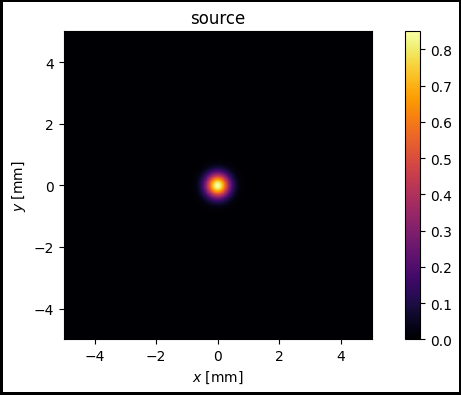

In [28]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'source')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

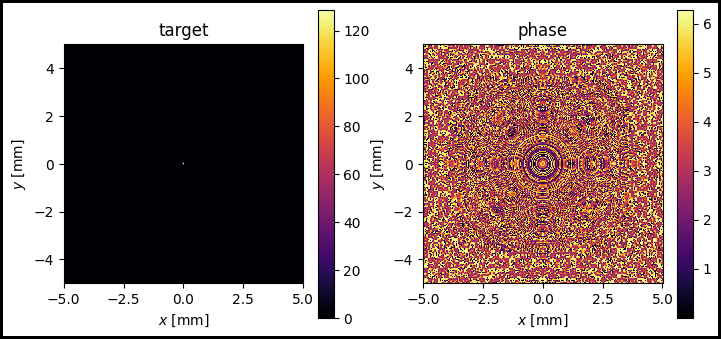

In [29]:
fig, ax = plt.subplots(
    1, 2, figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'target')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, phase_target, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title(r'phase')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

In [51]:

goal = torch.tensor((xv**2 + yv **2 <=2).astype(float))

# phase_distribution = phase_retrieval_problem.retrieve_phase(
#     source_intensity=torch.tensor(intensity_source),
#     optical_setup=optical_setup,
#     target_intensity=torch.tensor(intensity_target),
#     target_phase=torch.tensor(phase_target),
#     target_region=goal,
#     initial_phase=None,
#     method='HIO',
#     maxiter=20,
#     tol=1e-7
# )

phase_distribution = phase_retrieval_problem.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    target_phase=torch.tensor(phase_target),
    target_region=torch.tensor(goal),
    initial_phase=None,
    method='HIO',
    maxiter=15,
    tol=1e-7
)


step = 2 * torch.pi / 256
mask = phase_distribution // step

C:\Users\gunne\AppData\Local\Temp\ipykernel_22512\1575962153.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_region=torch.tensor(goal),


tensor(0.0012, dtype=torch.float64)
tensor(0.0036, dtype=torch.float64)
tensor(0.0034, dtype=torch.float64)
tensor(0.0021, dtype=torch.float64)
tensor(0.0016, dtype=torch.float64)
tensor(0.0014, dtype=torch.float64)
tensor(0.0017, dtype=torch.float64)
tensor(0.0012, dtype=torch.float64)
tensor(0.0012, dtype=torch.float64)
tensor(0.0011, dtype=torch.float64)
tensor(0.0012, dtype=torch.float64)
tensor(0.0011, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)
tensor(0.0021, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)
tensor(0.0011, dtype=torch.float64)


Интенсивность на картинке выше справа должны получить после оптимизации

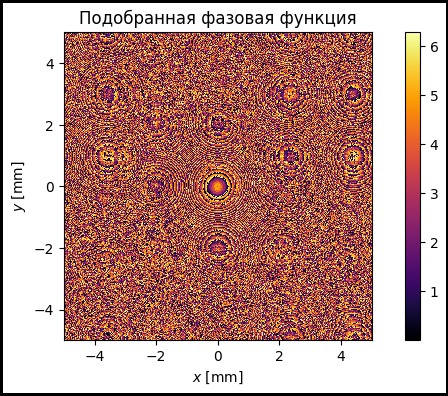

In [52]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_distribution, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Подобранная фазовая функция')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Снова решаем прямую задачу, но уже с подобранной маской:

In [53]:
# field_before_slm = beam_generator.GaussianBeam(simulation_parameters=params).forward(distance=distance, waist_radius=w0)

field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=mask).forward(field_before_lens1)

output_field = optical_setup.forward(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

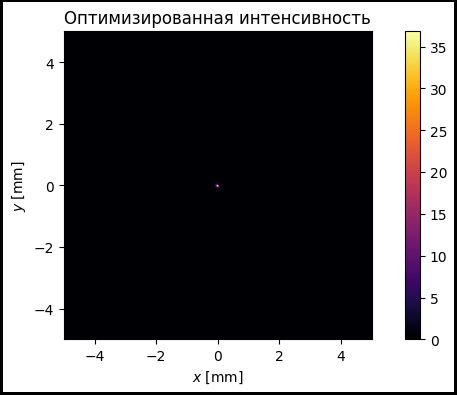

In [54]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Оптимизированная интенсивность')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [55]:
std = np.std(intensity_target - intensity_target_opt)
std

0.3643027623049183

In [56]:
phase_opt = (torch.angle(output_field) + 2 * torch.pi * (torch.angle(output_field) < 0.).float()).detach().numpy()

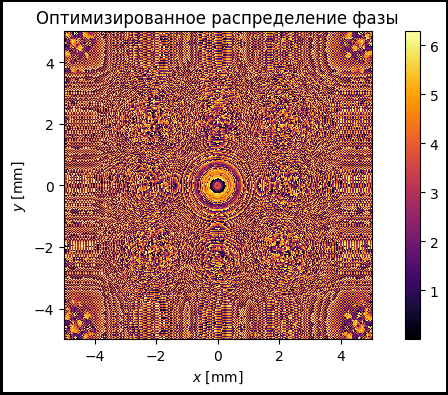

In [57]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Оптимизированное распределение фазы')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)